## Project 3 - Instacart (Clustering, Dimension Reduction, and Recommendation Engine)
This project & dataset comes from the Instacart kaggle competition.  Instacart is a grocery ordering and delivery app, allowing users to easily select products from their local grocery stores and have them delivered to their doorstep. 

In this project, Instacart would like to be able to predict which previously purchased products will be in a user's next order. 

The Instacart Online Grocery Shopping Dataset 2017”, Accessed from https://www.instacart.com/datasets/grocery-shopping-2017 on <date>

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import seaborn as sns
sns.set(style='whitegrid')

In [3]:
aisles = pd.read_csv('../data/raw/aisles.csv')
departments = pd.read_csv('../data/raw/departments.csv')
orders = pd.read_csv('../data/raw/orders.csv')
products = pd.read_csv('../data/raw/products.csv')
order_products_prior = pd.read_csv('../data/raw/order_products__prior.csv')
order_products_train = pd.read_csv('../data/raw/order_products__train.csv')


In [5]:
orders[orders.user_id == 23]

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
273,1792521,23,prior,1,5,14,NaN
274,8382,23,prior,2,0,10,9.0
275,1902489,23,prior,3,5,12,5.0
276,1072926,23,prior,4,3,11,30.0
277,3402036,23,train,5,1,12,30.0


In [11]:
order_products_prior[order_products_prior.order_id.isin([1792521, 8382, 1902489,1072926, 3402036])].product_id.value_counts().sort_index()

2138     1
3108     1
3243     1
3518     1
3873     1
3919     2
4210     1
4235     1
5404     1
7883     1
8524     1
13544    2
15359    1
17303    1
22021    1
23106    1
23734    1
25240    1
27325    1
28199    1
31268    1
33471    1
33819    2
33861    1
38241    1
39063    1
42372    1
42959    1
43014    1
43719    1
46572    1
47141    1
47504    1
48205    1
48871    2
49306    1
Name: product_id, dtype: int64

## Orders
This file provies us with a list of all orders in the provided dataset.  Each row represents a single order from a customer.  The products within each order are found within the 'order_products_prior' and 'order_products_train' datasets.  

As seen below, user 1 has 11 orders with Instacart.  The first 10 can be found within the 'order_products_prior' dataset, with order 11 contained in the 'order_products_train' dataset. 

In [239]:
orders[orders.user_id == 1]

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0
5,3367565,1,prior,6,2,7,19.0
6,550135,1,prior,7,1,9,20.0
7,3108588,1,prior,8,1,14,14.0
8,2295261,1,prior,9,1,16,0.0
9,2550362,1,prior,10,4,8,30.0


Let's have a look at our column structure:

In [240]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3421083 entries, 0 to 3421082
Data columns (total 7 columns):
order_id                  int64
user_id                   int64
eval_set                  object
order_number              int64
order_dow                 int64
order_hour_of_day         int64
days_since_prior_order    float64
dtypes: float64(1), int64(5), object(1)
memory usage: 182.7+ MB


We will convert the eval_set to a categorical value

In [241]:
orders['eval_set'] = pd.Categorical(orders['eval_set'])

## order_products_train / order_products_prior
As mentioned above, the order_products datasets contain the products that were ordered.  Building on user 1 from above, let's take a look at order number 11 (order_id=1187899).  We find that 11 products were ordered in total, 10 of which were re-ordered. 

This file does not give any details around what products was actually ordered - these details are contained in the products dataset. 

Order_products_prior contains the exact same schema as order_products_train

In [242]:
order_products_train[order_products_train.order_id == 1187899]

,order_id,product_id,add_to_cart_order,reordered
484420,1187899,196,1,1
484421,1187899,25133,2,1
484422,1187899,38928,3,1
484423,1187899,26405,4,1
484424,1187899,39657,5,1
484425,1187899,10258,6,1
484426,1187899,13032,7,1
484427,1187899,26088,8,1
484428,1187899,27845,9,0
484429,1187899,49235,10,1


## Products
Products contains the details around the product name and where it can be found in the grocery store (aisle_id).  The department_id relates the classification of the products (e.g. produce, frozen, bakery, beverages, etc).

In [243]:
products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


## Aisle
Contains the aisle id for the given product

In [244]:
aisles.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


## Departments
Contains the department name for each product

In [245]:
departments.head(15)

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol
5,6,international
6,7,beverages
7,8,pets
8,9,dry goods pasta
9,10,bulk


## When Do Customers Shop?
Let's have a look at the hours users create orders

### Hour of Day
It appears that the most popular time to shop is between 08:00 - 18:00.

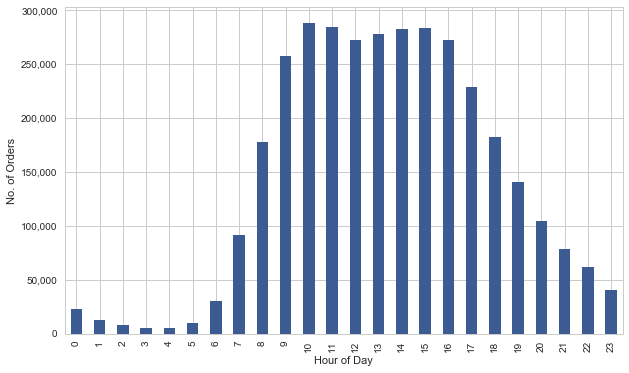

In [247]:
# create plot
fig, ax = plt.subplots(figsize=(10, 6))

# create plot
orders.groupby('order_hour_of_day').order_id.count().plot(kind='bar', color=sns.xkcd_rgb["denim blue"])

# set axis names
plt.ylabel('No. of Orders')
plt.xlabel('Hour of Day')

# format values with comma
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

# save 
plt.savefig('../reports/figures/orders_per_hour.png', bbox_inches='tight')

plt.show()

### Day of Week
The most popular days of the week are 0 and 1.  Instacart has not provided a mapping for the day of week column, but the assumption is that 0 corresponds to a Saturday or Sunday.  Mid week values (3,4) would represent the lowest shopping period.

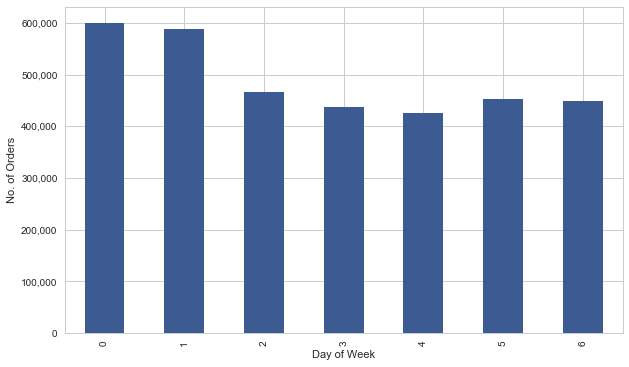

In [248]:
# create plot
fig, ax = plt.subplots(figsize=(10, 6))

# create plot
orders.groupby('order_dow').order_id.count().plot(kind='bar', color=sns.xkcd_rgb["denim blue"])

# set axis names
plt.ylabel('No. of Orders')
plt.xlabel('Day of Week')

# format values with comma
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

# save 
plt.savefig('../reports/figures/orders_per_day.png', bbox_inches='tight')

plt.show()

### Days Since Last Order
It apperas that there are trends in how often users are reordering, with weekly and monthly being very frequent indicators.  We see jumps in the 7, 14, 21 reorder dates as well.  

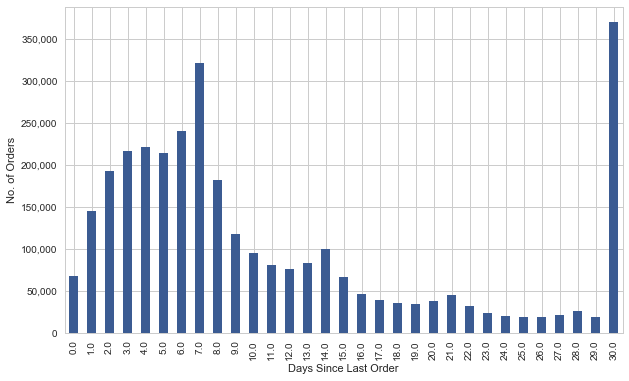

In [249]:
# create plot
fig, ax = plt.subplots(figsize=(10, 6))

# create plot
orders.groupby('days_since_prior_order').order_id.count().plot(kind='bar', color=sns.xkcd_rgb["denim blue"])

# set axis names
plt.ylabel('No. of Orders')
plt.xlabel('Days Since Last Order')

# format values with comma
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

# save 
plt.savefig('../reports/figures/days_since_last_order.png', bbox_inches='tight')

plt.show()

### Number of Prior Orders
Each customer has prior and train orders, with train being the most recent order.  When looking at the data, how many prior orders do we have for each customer? 

Based on the graph below, we see that we have a consistent number for orders 1, 2, 3.  This means that for every customer in our dataset, we have at least 3 prior orders & 1 current order.

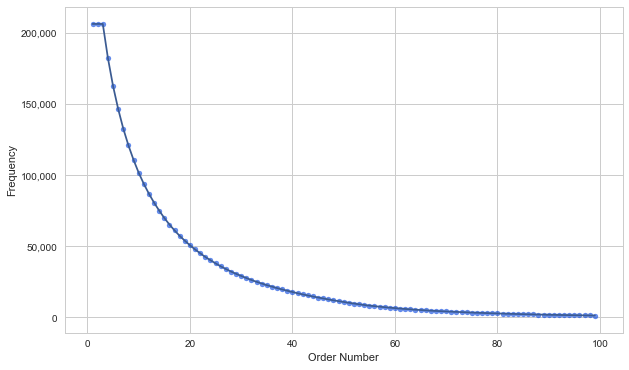

In [250]:
# create plot
fig, ax = plt.subplots(figsize=(10, 6))

# group and summarize by oder number - this allows us to see how many order '1', '2', '3', etc
# we have in the dataset
prior_orders = orders[orders.eval_set == 'prior'].groupby('order_number').order_id.count()

# find x and y
x = prior_orders.index
y = prior_orders.values

# create line plot
plt.plot(x,y,color=sns.xkcd_rgb["denim blue"])

# create dots on our line plot
plt.scatter(x, y, color=sns.xkcd_rgb["blue"], alpha=0.6, s=25)

# set labels
plt.ylabel('Frequency')
plt.xlabel('Order Number')
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

plt.savefig('../reports/figures/prior_orders.png', bbox_inches='tight')

plt.show()

### Items Per Order
Lets look at how many items are purchased per order:

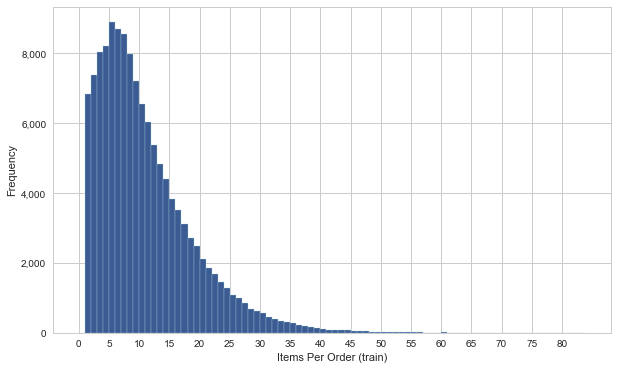

In [256]:
# create plot
fig, ax = plt.subplots(figsize=(10, 6))

# create bins
bins = np.arange(0, 85, 1)

# create plot
order_products_train.groupby('order_id').product_id.count().plot(kind='hist', 
                                                                 bins=bins, 
                                                                 color=sns.xkcd_rgb["denim blue"],
                                                                edgecolor='lightblue')

# set labels
plt.xlabel('Items Per Order (train)')
plt.xticks(np.arange(min(bins), max(bins)+1, 5.0))
# format y values
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

# save 
plt.savefig('../reports/figures/items_per_order.png', bbox_inches='tight')

plt.show()

In [257]:
order_products_train.groupby('order_id').product_id.count().describe()

count    131209.000000
mean         10.552759
std           7.932847
min           1.000000
25%           5.000000
50%           9.000000
75%          14.000000
max          80.000000
Name: product_id, dtype: float64

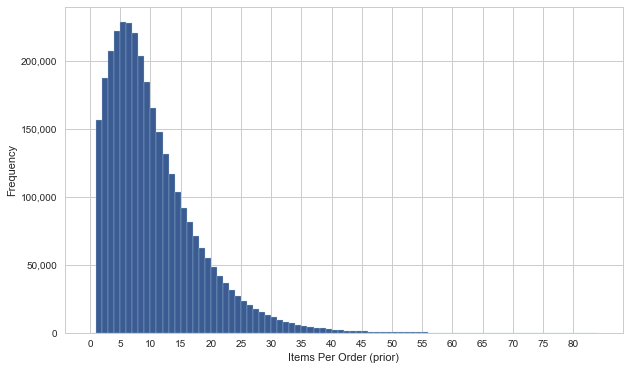

In [258]:
# create plot
fig, ax = plt.subplots(figsize=(10, 6))

# create bins
bins = np.arange(0, 85, 1)

# create plot
order_products_prior.groupby('order_id').product_id.count().plot(kind='hist', 
                                                                 bins=bins, 
                                                                 color=sns.xkcd_rgb["denim blue"],
                                                                edgecolor='lightblue')

# set labels
plt.xlabel('Items Per Order (prior)')
plt.xticks(np.arange(min(bins), max(bins)+1, 5.0))
# format y values
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

# save 
plt.savefig('../reports/figures/items_per_order_prior.png', bbox_inches='tight')

plt.show()

In [259]:
order_products_prior.groupby('order_id').product_id.count().describe()

count    3.214874e+06
mean     1.008888e+01
std      7.525398e+00
min      1.000000e+00
25%      5.000000e+00
50%      8.000000e+00
75%      1.400000e+01
max      1.450000e+02
Name: product_id, dtype: float64

We see that on average, users purchase 10 items per order.  The distribution of items is heavily skewed in both the train and prior datasets, with the peak at 5 items per order. 

### Most Popular Products
Knowing how many items per order, do we know what are the most popular items?  It appears tha thte most popular products are fruits: Bananas, Organic Bananas and Organic Strawberries.

In [274]:
# Find the most popular products
most_popular = pd.DataFrame(order_products_train.groupby('product_id').order_id.count().sort_values(ascending=False)).reset_index()
most_popular.columns = ['product_id', 'popularity']

# Join with the products data frame to find names
popular_prod = pd.merge(products, most_popular, on='product_id')
popular_prod.sort_values('popularity', ascending=False)[:10]

,product_id,product_name,aisle_id,department_id,popularity
19574,24852,Banana,24,4,18726
10367,13176,Bag of Organic Bananas,24,4,15480
16685,21137,Organic Strawberries,24,4,10894
17300,21903,Organic Baby Spinach,123,4,9784
37499,47626,Large Lemon,24,4,8135
37609,47766,Organic Avocado,24,4,7409
37164,47209,Organic Hass Avocado,24,4,7293
13228,16797,Strawberries,24,4,6494
20648,26209,Limes,24,4,6033
22024,27966,Organic Raspberries,123,4,5546


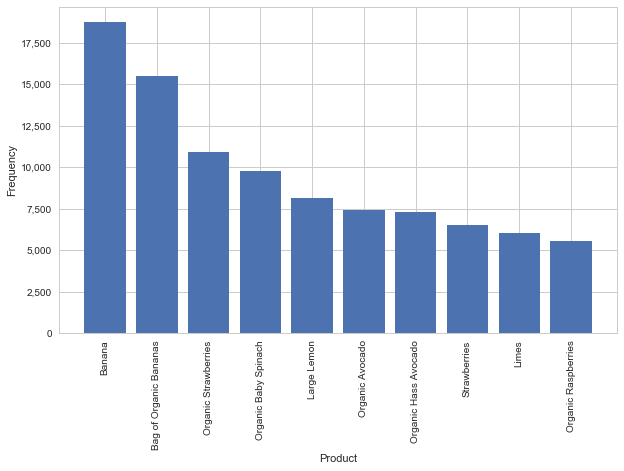

In [325]:
# create plot
fig, ax = plt.subplots(figsize=(10, 6))

# find top 10 products
popular_prod10 = popular_prod[['product_name', 'popularity']].sort_values('popularity', ascending=False)[:10]

# find axis values
names = popular_prod10.product_name
values = popular_prod10.popularity
ind = np.arange(0, len(names))

# plot
plt.bar(ind, values)
plt.xticks(ind, names, rotation=90)

# set labels
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.ylabel('Frequency')
plt.xlabel('Product')

# save fig
plt.savefig('../reports/figures/most_popular_items.png', bbox_inches='tight')

plt.show()

In [ ]:
how ofter do people reorder to the same items?

### Added First To Cart
Looking at the products ordered, how often is a product added to a cart first?

We tackle this by looking at products that have been ordered at least 11 times - This ensures we have a larger sampling of orders to base our assumptions on.  From this subset of products, 
we then compute for the orders where product 'x' was ordered, how often is product 'x' added as the first item? 

In [471]:
# find the total number of orders for each product, and filter to only include products > 10 ordres
total_ordered = order_products_train.groupby('product_id').order_id.count()
total_ordered = total_ordered[total_ordered > 10]

In [472]:
# get products in our total_ordered dataset that have been ordered 1st
products_added_first = order_products_train[(order_products_train.product_id.isin(total_ordered.index)) & 
                     (order_products_train.add_to_cart_order == 1)]

# group by productId and get a count for each productID
products_added_first = products_added_first.groupby('product_id').add_to_cart_order.count()

# find the percentage that the item was added first in the orders
df_first = pd.DataFrame((products_added_first / total_ordered).reset_index())
df_first.columns = ['product_id', 'percentage']
df_first = pd.merge(df_first, products, on='product_id').sort_values('percentage', ascending=False)

In [473]:
# convert to dataframe & rename columns
total_ordered = pd.DataFrame(total_ordered.reset_index())
total_ordered.columns = ['product_id', 'purchase_freq']

# merge with df_first and display results
df_first = pd.merge(df_first, total_ordered, on='product_id')
df_first[:15]

,product_id,percentage,product_name,aisle_id,department_id,purchase_freq
0,45004,0.661017,White Multifold Towels,54,17,59
1,11345,0.625000,Irish Whiskey Ireland,124,5,16
2,13855,0.615385,NyQuil Severe Cold & Flu and DayQuil Severe Co...,11,11,13
3,11885,0.594203,"Sparkling Water, Bottles",115,7,69
4,1993,0.588235,Cheesecake,8,3,17
5,13128,0.571429,Purified Alkalkine Water with Minerals pH10,115,7,21
6,4100,0.560000,Organic Dark Roast,26,7,25
7,34568,0.538462,Bourbon Kentucky Frontier Whiskey,124,5,13
8,1729,0.521739,2% Lactose Free Milk,84,16,92
9,34148,0.500000,Variety of Anitoxidant Infusions Cans,64,7,18


We now have an idea of how often a product is added first when added to an order.  The results show us that when White Multifold Towels are purchased, they are added as the first item 66% of the time.  Similarily, when cheesecake is purchased, it is added as the first item 58% of the time. 

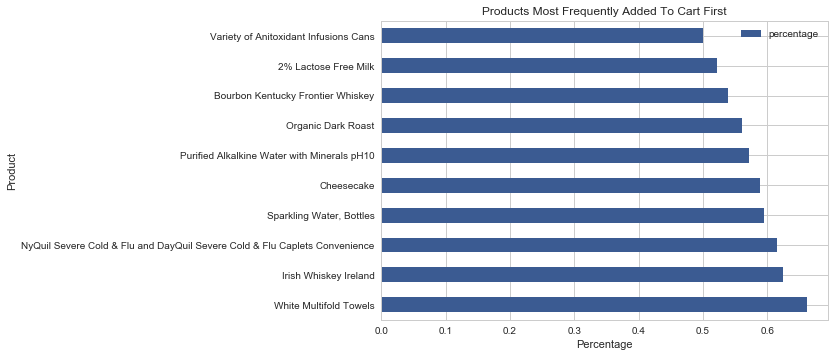

In [474]:
# show our results
df_first[:10].plot('product_name', 'percentage', kind='barh', color=sns.xkcd_rgb['denim blue'],)

# set labels
plt.title('Products Most Frequently Added To Cart First')
plt.xlabel('Percentage')
plt.ylabel('Product')

# save file
plt.savefig('../reports/figures/Added_To_Cart_First.png', bbox_inches='tight')

plt.show()

### Products Sold By Department
Each department is divided into aisles.  Lets have a look at how products sold make up each department by aisle.

First, we join the ordered products with the appropriate product, aisles and department names.

In [479]:
order_products = pd.merge(order_products_train, products, on='product_id')
order_products = pd.merge(order_products, aisles, on='aisle_id')
order_products = pd.merge(order_products, departments, on='department_id')

With a combined dataset, we can now examine our dataset to find the most frequented departments.  Based on the graph below, we see that Produce and Dairy/Eggs are the top departments

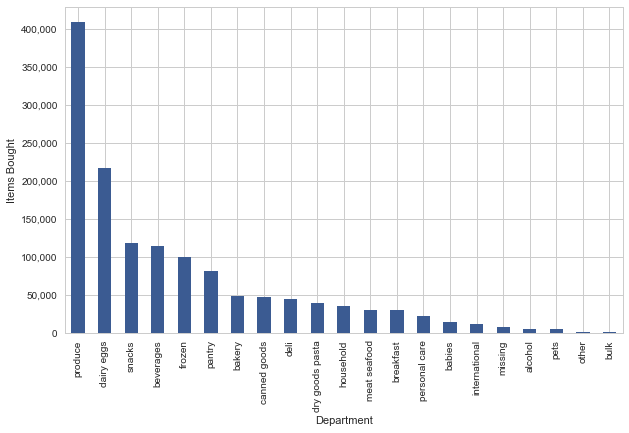

In [621]:
# create figure
fig, ax = plt.subplots(figsize=(10, 6))

# create plot
order_products.groupby('department').order_id.count().sort_values(ascending=False).plot(kind='bar',color=sns.xkcd_rgb["denim blue"])

# set labels
plt.ylabel('Items Bought')
plt.xlabel('Department')
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

# save file
plt.savefig('../reports/figures/Items_Bought_by_Dept.png', bbox_inches='tight')

plt.show()

Concerning the top 6 departments, how are the purchases broken down by aisle? 

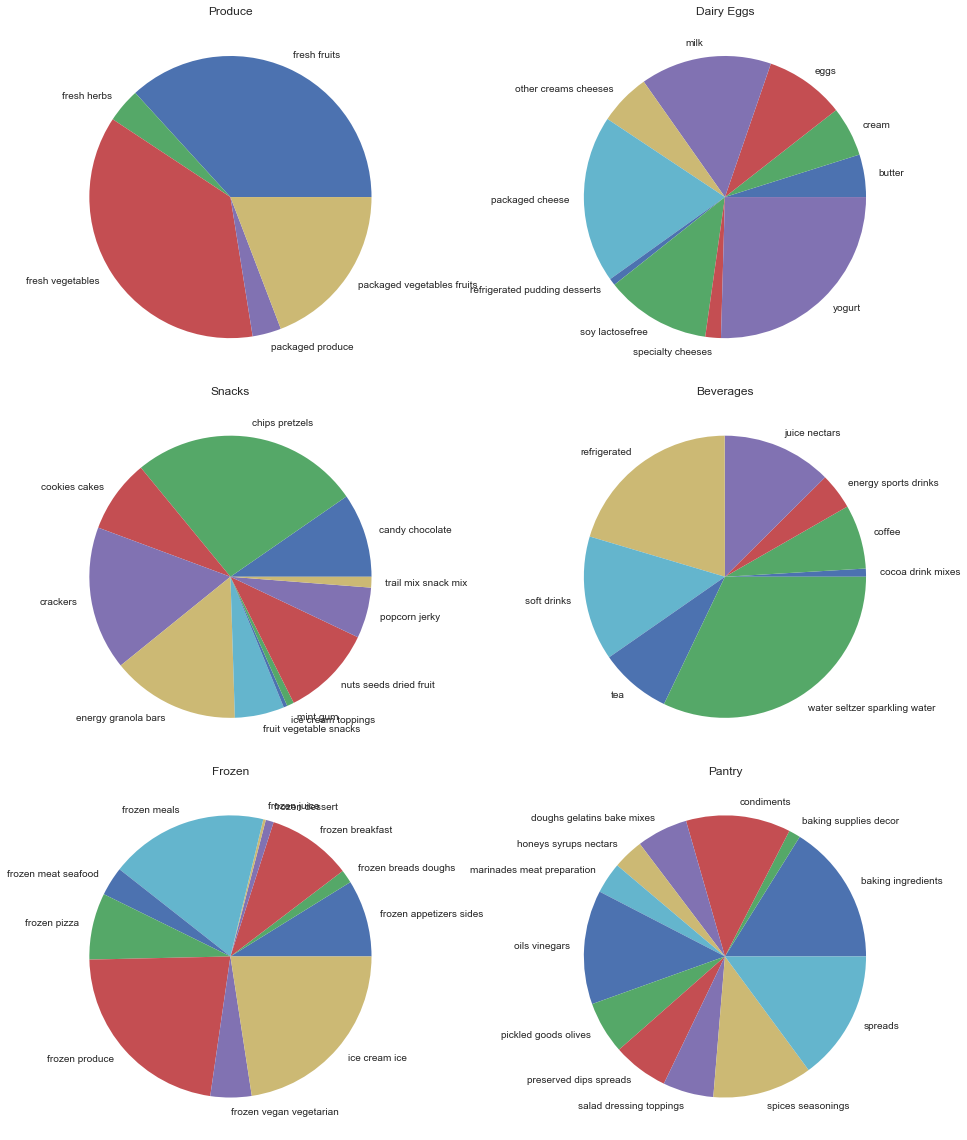

In [620]:
# top 6 departments
top_dept = order_products.groupby('department').order_id.count().sort_values(ascending=False).index[:6]

# define number of subplots & columns
total_subplots = len(top_dept)
total_cols = 2

# determine the number of rows required
total_rows = total_subplots // total_cols
total_rows += total_subplots % total_cols

# setup subplot position
pos = range(1, total_subplots+1)

# create plot
fig = plt.figure(figsize=(16,16))
i=0

# determine positions
for dept, row_dept in order_products[order_products.department.isin(top_dept)].groupby('department').order_id.count().sort_values(ascending=False).iteritems():

    # filter products to our current deptarment
    order_products_filtered = order_products[order_products.department == dept]
        
    # set aisle values
    aisle_values = order_products_filtered.groupby(['department','aisle']).order_id.count().values
    aisle_labels = order_products_filtered.groupby(['department','aisle']).order_id.count().index.get_level_values('aisle')

    # create pie chart
    ax = fig.add_subplot(total_rows, total_cols, pos[i])
    ax.pie(aisle_values, radius=1, labels=aisle_labels)
    ax.set(aspect='equal')
    
    # add a title
    ax.set_title(dept.title())

    # increase subplot position
    i+=1

# plot
plt.tight_layout()

# save file
plt.savefig('../reports/figures/departments_aisles.png', bbox_inches='tight')
plt.show()    
   

### What are the top 10 aisles? 

In [689]:
def create_colormap(values):
    '''
        Takes a list of departments that require unique color codes
        and returns an array of colors
    
        Parameters
        ----------
        values: The list of departments for which colors should be created
    '''

    # create enough colors to map to the unqiue values
    col_brew = sns.color_palette('husl', len(np.unique(values)))

    # assign a unique color to each value
    colormap = {}
    for v in values:
        if v not in colormap.keys():
            colormap[v] = col_brew.pop()

    # return color array for given values
    return [colormap[v] for v in values]

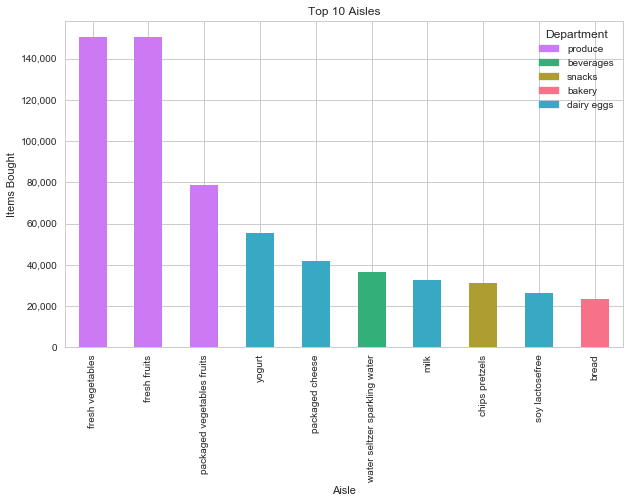

In [709]:
import matplotlib.patches as mpatches

# create figure
fig, ax = plt.subplots(figsize=(10, 6))

# find top aisle
top_aisle = order_products.groupby('aisle').order_id.count().sort_values(ascending=False)[:10]

dept = []

# loop through aisles and find the corresponding department
for aisle in top_aisle.index:
    dept.append(order_products[order_products.aisle==aisle].department.unique()[0])

# get color array
colors = create_colormap(dept)

# plot results
top_aisle.plot(kind='bar', color=colors)

# set labels
plt.title('Top 10 Aisles')
plt.ylabel('Items Bought')
plt.xlabel('Aisle')
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

# create legend
handles=[]
for c, l in set(zip(colors, dept)):
    h = mpatches.Patch(color=c, label=l)
    handles.append(h)

# save file
plt.savefig('../reports/figures/Items_Bought_by_Aisle_by_Dept.png', bbox_inches='tight')

# show
plt.legend(handles=handles, title='Department')
plt.show()